In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt

# --- Configurações ---
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Rodando no dispositivo: {device}")

block_size = 64
batch_size = 16
max_iters = 5000 
learning_rate = 1e-3
eval_iters = 200
n_embd = 128 
n_layer = 4
n_head = 4 
dropout = 0.2 

# Meta: Tente fazer a val loss (perda de validação) cair para abaixo de 1.7.
# Loss > 2.0: Balbucios.
# Loss ~ 1.5: Frases curtas fazem sentido.
# Loss < 1.0: Texto quase perfeito.

Rodando no dispositivo: cpu


In [ ]:
files = ['wizard_of_oz.txt', 'alice_in_wonderland.txt', 'peter_pan.txt']
text = ""
for file_name in files:
    with open(file_name, 'r', encoding='utf-8') as f:
        text += f.read() + "\n" # Adiciona uma quebra de linha entre livros

print(f"Tamanho total do dataset: {len(text)} caracteres")
    
chars = sorted(list(set(text)))

vocab_size = len(chars)

Tamanho total do dataset: 625251 caracteres
95


In [3]:
string_to_int = { ch:i for i,ch in enumerate(chars) }
int_to_string = {i:ch for i,ch in enumerate(chars) }
encode = lambda s: [string_to_int[c] for c in s]
decode = lambda l: ''.join([int_to_string[i] for i in l])

data = torch.tensor(encode(text), dtype=torch.long)

In [4]:
n = int(0.8*len(data))
train_data = data[:n]
val_data = data[n:]

In [5]:
# --- Funções Auxiliares ---
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x.to(device), y.to(device)

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [6]:
#Head é o mecanismo de "comunicação". 
# É onde os tokens olham uns para os outros e decidem quem é relevante para quem. 
# O tril (máscara triangular) garante que, ao tentar prever a 5ª palavra, o modelo só possa olhar para as palavras 1, 2, 3 e 4, e nunca para a 6ª (futuro).
class Head(nn.Module):
    """ uma cabeça de auto-atenção (self-attention) """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        # O buffer 'tril' é a máscara triangular inferior para garantir que 
        # o modelo não "olhe para o futuro" (causal masking)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input de tamanho (batch, time-step, channels) = (B,T,C)
        B, T, C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        
        # computa os scores de atenção ("afinidade")
        # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = q @ k.transpose(-2, -1) * C**-0.5 
        
        # Aplica a máscara: tudo que é 0 vira -infinito (para o softmax ignorar)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) 
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        
        # realiza a agregação ponderada dos valores
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

#MultiHeadAttention é como ter várias "opiniões" diferentes. 
# Uma cabeça pode focar na gramática, outra em nomes próprios, outra na relação sujeito-verbo. 
# O modelo aprende essas especializações sozinho.
class MultiHeadAttention(nn.Module):
    """ múltiplas cabeças de atenção em paralelo """

    def __init__(self, num_heads, head_size):
        super().__init__()
        # Cria uma lista de módulos Head independentes
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        # Projeção final para misturar os resultados das cabeças
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Concatena os resultados na dimensão dos canais (última dimensão)
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

#FeedForward é o mecanismo de "computação" ou "reflexão". 
# Depois que os tokens trocam informações na Atenção, eles "pensam" sobre essa informação individualmente nesta camada densa antes de passar para o próximo bloco.
class FeedForward(nn.Module):
    """ uma camada linear simples seguida de não-linearidade """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            # A camada interna geralmente expande por um fator de 4 (padrão do paper original)
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd), # Projeta de volta para o tamanho original
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
    def forward(self, x):
        y = self.sa(x)
        x = self.ln1(x + y)
        y = self.ffwd(x)
        x = self.ln2(x + y)
        return x
        
class GPTLanguageModel(nn.Module):
    def __init__(self): # Removido vocab_size do argumento pois já é global, ou passe explicitamente
        super().__init__()
        # Correção da dimensão de saída para n_embd
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)
        
        # Correção do nome da função
        self.apply(self._init_weights)

    def _init_weights(self, module): # Correção dos underscores
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, index, targets=None):
        B, T = index.shape
        
        # Correção: usar 'index' e não 'idx'
        tok_emb = self.token_embedding_table(index) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            # Correção: Cortar o contexto para não estourar o block_size
            idx_cond = idx if idx.size(1) <= block_size else idx[:, -block_size:]

            # Pega as previsões
            logits, _ = self(idx_cond)

            # Foca apenas no último passo de tempo (o último token)
            logits = logits[:, -1, :] # vira (B, C)

            # Aplica softmax para obter probabilidades
            probs = F.softmax(logits, dim=-1) # (B, C)

            # Amostra (sorteia) o próximo token baseado nas probabilidades
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)

            # Adiciona o novo token à sequência (concatena)
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [7]:
# Instanciar o Modelo
model = GPTLanguageModel()
m = model.to(device)
print(f"Modelo criado com {sum(p.numel() for p in m.parameters())/1e6:.2f} M parâmetros")
# Pra fim comparativo o GPT 1 da OPENAI teve em 2018 117 MILHÕES de parametros

Modelo criado com 0.82 M parâmetros


In [8]:
# Otimizador
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [9]:
# Loop com historico
loss_history_train = []
loss_history_val = []

print(f"Iniciando treinamento unificado de {max_iters} passos...")

for iter in range(max_iters):
    
    # Avaliação e Log
    if iter % eval_iters == 0:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        loss_history_train.append(losses['train'])
        loss_history_val.append(losses['val'])

    # Treino
    xb, yb = get_batch('train')
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print("Treinamento finalizado.")

# Plotagem do Gráfico
plt.figure(figsize=(10, 6))
plt.plot(loss_history_train, label='Treino')
plt.plot(loss_history_val, label='Validação')
plt.title('Evolução da Loss (3 Livros Combined)')
plt.xlabel(f'Iterações (x {eval_iters})')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('grafico_loss_3livros.png')
print("Gráfico salvo: grafico_loss_3livros.png")

Iniciando treinamento unificado de 5000 passos...
step 0: train loss 4.5731, val loss 4.5728
step 200: train loss 2.3770, val loss 2.4139
step 400: train loss 2.1572, val loss 2.2207
step 600: train loss 2.0311, val loss 2.0905
step 800: train loss 1.9028, val loss 1.9723
step 1000: train loss 1.8358, val loss 1.9284
step 1200: train loss 1.7836, val loss 1.8654
step 1400: train loss 1.7439, val loss 1.8381
step 1600: train loss 1.7071, val loss 1.8047
step 1800: train loss 1.6822, val loss 1.7768
step 2000: train loss 1.6519, val loss 1.7391
step 2200: train loss 1.6283, val loss 1.7277
step 2400: train loss 1.6150, val loss 1.7164
step 2600: train loss 1.5950, val loss 1.7012
step 2800: train loss 1.5839, val loss 1.6811
step 3000: train loss 1.5657, val loss 1.6866
step 3200: train loss 1.5527, val loss 1.6651
step 3400: train loss 1.5338, val loss 1.6559
step 3600: train loss 1.5255, val loss 1.6431
step 3800: train loss 1.5185, val loss 1.6390
step 4000: train loss 1.5059, val los

NameError: name 'plt' is not defined

In [10]:
# Geração de Texto 
print("\n" + "="*30)
print("GERANDO TEXTO COM O MODELO FINAL")
print("="*30 + "\n")

model.eval()
context = torch.zeros((1, 1), dtype=torch.long, device=device)
generated_ids = model.generate(context, max_new_tokens=500)
print(decode(generated_ids[0].tolist()))


GERANDO TEXTO COM O MODELO FINAL


"I guing stood the string with quite such a grown lifere
mens be leave a mother down round her proped out, and goo there, and he
liked out sound enquite but, when yhumbug in a
readful you on," said the ugs; "but I willu sleep," in answered the Queen excection
from a thing to the Wuk-inging-day to see that into him and the grew the
carriess were gett into the
that, which a little be lages they said the lagowing to and becout to big
her, and he nined to other day her to be, bore vision—the own the


In [11]:
torch.save(model.state_dict(), 'modelo_final_3livros.pth')
print("Modelo final salvo!")

Modelo final salvo!


Gráfico salvo: grafico_loss_3livros.png


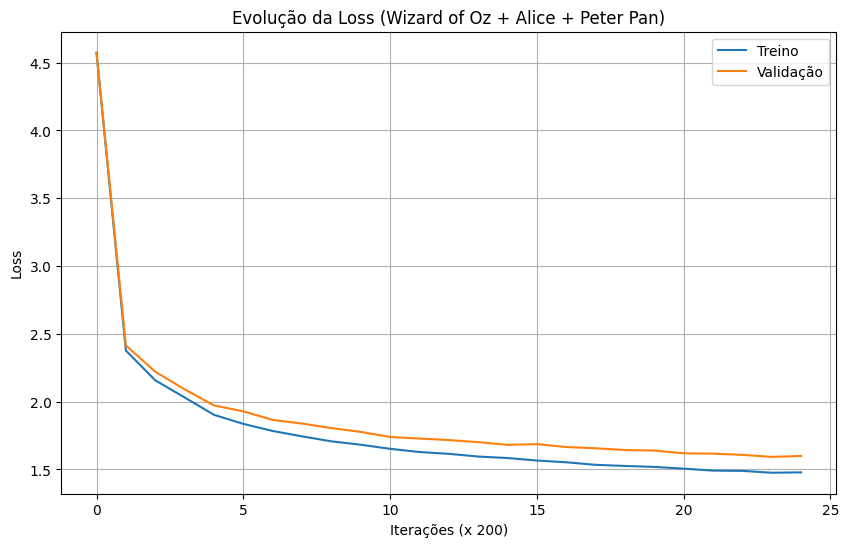

In [12]:
import matplotlib.pyplot as plt  # Essa linha estava faltando

# Como os dados já estão na memória, é só plotar:
plt.figure(figsize=(10, 6))
plt.plot(loss_history_train, label='Treino')
plt.plot(loss_history_val, label='Validação')
plt.title('Evolução da Loss (Wizard of Oz + Alice + Peter Pan)')
plt.xlabel('Iterações (x 200)')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('grafico_loss_3livros.png')
print("Gráfico salvo: grafico_loss_3livros.png")